In [1]:

%pip -q install gtbook # also installs latest gtsam pre-release

In [2]:
# Save the factor graph as a Graphviz DOT file
# gtsam.gtsam.writeG2o(graph, optimized_values, "factor_graph12.dot")

[0.34847556 0.         0.        ]
constrained sigmas [0.348475565; 0; 0];
constrained mu [1000; 1000; 1000];

[0.76152005 0.         0.        ]
constrained sigmas [0.761520054; 0; 0];
constrained mu [1000; 1000; 1000];

[8.14319251 0.         0.        ]
constrained sigmas [8.14319251; 0; 0];
constrained mu [1000; 1000; 1000];

[0.40430465 0.         0.        ]
constrained sigmas [0.404304652; 0; 0];
constrained mu [1000; 1000; 1000];

[0.69814788 0.         0.        ]
constrained sigmas [0.698147883; 0; 0];
constrained mu [1000; 1000; 1000];


Factor Graph:
NonlinearFactorGraph: size: 71

Factor 0: PriorFactor on 0
  prior mean:  (288, 192, 0)
  noise model: diagonal sigmas [5; 5; 0.0872664626];

Factor 1: BetweenFactor(0,1)
  measured:  (-10.4542669, 130.626051, -0.0271380026)
  noise model: constrained sigmas [0.348475565; 0; 0];
  noise model: constrained mu [1000; 1000; 1000];

Factor 2: BetweenFactor(1,0)
  measured:  (-10.4542669, 130.626051, -0.0271380026)
  noise model: co

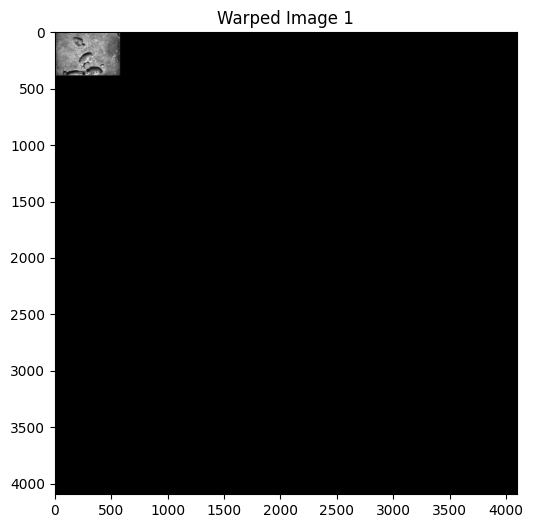

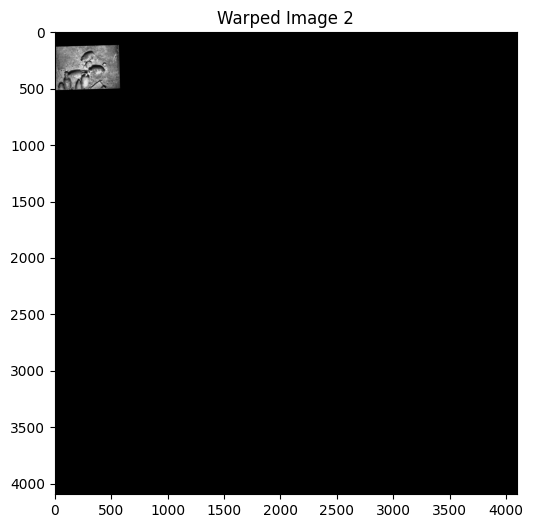

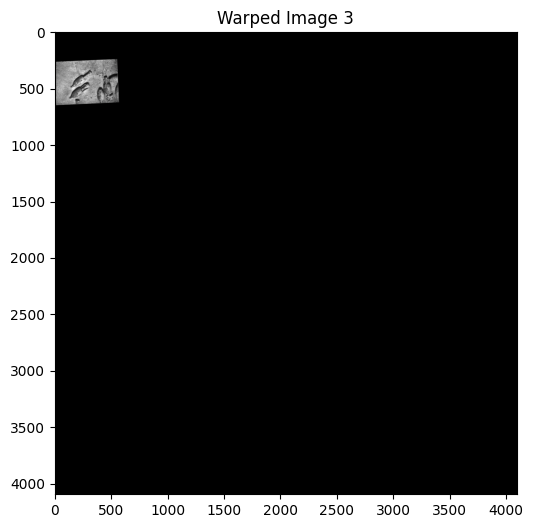

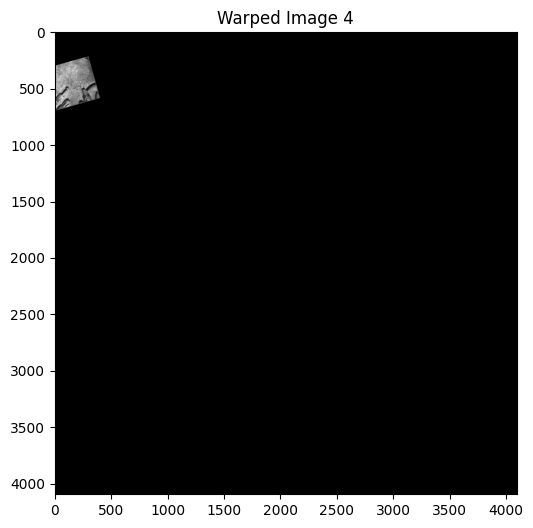

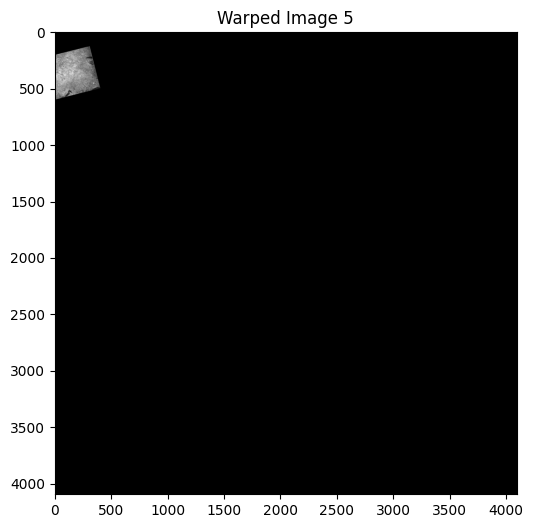

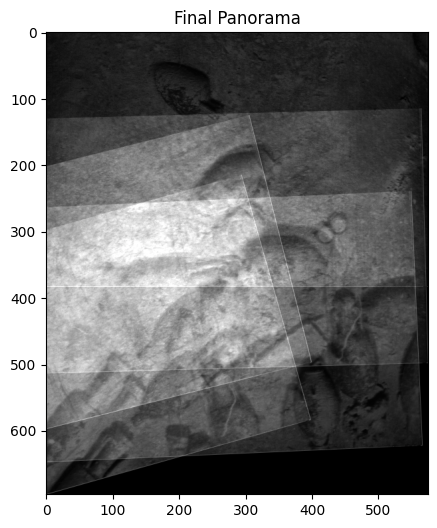

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import gtsam
import itertools
import math
import gtsam.utils.plot as gtsam_plot

# Folder containing image pairs
# image_folder = '/content/drive/MyDrive/6Images'
image_folder = 'Images/6Images'

# Get a list of image files in the folder
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.tif', '.bmp'))]

# Sort the image files to ensure they are in the correct order
# image_files.sort()

# Initialize an empty list to store the loaded and normalized images
images = []

# Initialize CLAHE (Contrast Limited Adaptive Histogram Equalization)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

# Load and enhance each image file individually
for img_file in image_files:
    img_path = os.path.join(image_folder, img_file)
    image = cv2.imread(img_path)

    # Apply CLAHE for local contrast enhancement
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l_channel, a_channel, b_channel = cv2.split(lab_image)
    l_channel = clahe.apply(l_channel)
    enhanced_lab_image = cv2.merge((l_channel, a_channel, b_channel))
    enhanced_image = cv2.cvtColor(enhanced_lab_image, cv2.COLOR_LAB2BGR)

    images.append(enhanced_image)


# Initialize empty canvases for the left panorama
height, width, _ = images[0].shape
# panorama_size = (width * 2, height * len(images))
panorama_size = (4096, 4096)

# Initialize blank canvas for the final panorama
stitched_panorama = np.zeros((panorama_size[1], panorama_size[0], 3), np.uint8)

# Initialize an identity matrix as the cumulative homography matrix
cumulative_homography = np.eye(3)

# Initialize translation matrix
translation = np.array([[1, 0, panorama_size[0] / 2], [0, 1, panorama_size[1] / 2], [0, 0, 1]])

# Initialize updated homographies list
updated_homographies = []
# Initialize lists to store keypoints and descriptors for each image
keypoints_list = []
descriptors_list = []

# Create a SIFT detector
sift = cv2.SIFT_create(nfeatures=4000, nOctaveLayers=12, contrastThreshold=0.025, sigma=1.5)

# Initialize a list to store the number of keypoints before and after RANSAC
keypoints_before_ransac = []
keypoints_after_ransac = []

# Initialize a list to store the number of matches before and after RANSAC
matches_before_ransac = []
matches_after_ransac = []

# Initialize a list to store the transformed images
transformed_images = []

ERF_DIV = 50
LIN_DIV = 30

# Create GTSAM factor graph
graph = gtsam.NonlinearFactorGraph()
prior_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([5, 5, np.deg2rad(5)]))
graph.add(gtsam.PriorFactorPose2(0, gtsam.Pose2(width/2, height/2, 0), prior_noise))

params = gtsam.LevenbergMarquardtParams()
# Initialize a list to store the poses before LM optimization
poses_before_lm = []

initial_pose = gtsam.Pose2(0, 0, 0)
initial_estimate = gtsam.Values()
initial_estimate.insert(0, initial_pose)


from itertools import combinations
pairs = set(combinations(range(len(images)), 2))
# Detect keypoints and compute descriptors for each image
for image in images:
    # Detect keypoints and compute descriptors
    keypoints, descriptors = sift.detectAndCompute(image, None)

    # Append keypoints and descriptors to the lists
    keypoints_list.append(keypoints)
    descriptors_list.append(descriptors)

# Check to see if there is overlap where the euclidean distance is less than 80% of the image width
def check_overlap(pose_1, pose_2):
    return cv2.norm(pose_1.translation()-pose_2.translation()) < width*.8

# Optimize the graph after each image pair registration
for i in range( len(images)-1):
    # Match descriptors between the current image and the center image
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors_list[i], descriptors_list[i + 1], k=2)

    # Apply ratio test to select good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.88 * n.distance:
            good_matches.append(m)

    # Store the number of matches before RANSAC
    matches_before_ransac.append(len(good_matches))

    # Check if there are enough good matches to calculate the homography
    if len(good_matches) < 4:
        print(f"Image {i + 1} - Not enough good matches for homography.")
        continue

     # Calculate the homography matrix
    dst_pts = np.float32([keypoints_list[i][m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    src_pts = np.float32([keypoints_list[i + 1][m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    homography, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5)
    homography /= homography[2, 2]

    # Update the cumulative homography matrix
    cumulative_homography = np.dot(cumulative_homography, homography)

    # Update the translation matrix
    updated_homography = np.dot(translation, cumulative_homography)
    updated_homographies.append(updated_homography)

    # Insert the initial estimate for the current pose
    initial_estimate.insert(i+1, gtsam.Pose2(cumulative_homography[0, 2], cumulative_homography[1, 2], np.arctan2(cumulative_homography[1, 0], cumulative_homography[0, 0])))
    # Add a BetweenFactorPose2 to the GTSAM graph

    # Extract translation and rotation components from the  homography matrix
    dx = homography[0, 2]  # Change in x (translation in x-axis)
    dy = homography[1, 2]  # Change in y (translation in y-axis)
    dth = np.arctan2(homography[1, 0], homography[0, 0])  # Change in orientation (rotation)

    covar_multiplier = 1/math.erf((len(good_matches)-3)/ERF_DIV)
    exx = abs(dx/LIN_DIV) * covar_multiplier
    eyy = abs(dy/LIN_DIV) * covar_multiplier
    ett = abs(dth/(LIN_DIV * 10.0)) * covar_multiplier
    exy = 0 * covar_multiplier
    ext = 0 * covar_multiplier
    eyt = 0 * covar_multiplier

    covariance = [[exx, exy, ext],
                  [eyt, eyy, eyt],
                  [ext, exy, ett]]
    covariance = np.array(covariance)
    covariance_vector = covariance.flatten()[:3]
    print(covariance_vector)
    cov = gtsam.noiseModel.Diagonal.Sigmas(covariance_vector)
    print(cov)
    pose_bet = gtsam.Pose2(homography[0, 2], homography[1, 2], np.arctan2(homography[1, 0], homography[0, 0]))
    # Generate permutations
    # Track added factors
    added_factors = set()
    import itertools
    pose_pairs = itertools.permutations(range(len(images)), 2)

    for a, b in pose_pairs:

      # Only add new factors
      if (a, b) not in added_factors:

        if initial_estimate.exists(a) and initial_estimate.exists(b):

          if check_overlap(initial_estimate.atPose2(a), initial_estimate.atPose2(b)):

            # Add factor
            graph.add(gtsam.BetweenFactorPose2(a, b, pose_bet, cov))

            # Track added factor
            added_factors.add((a, b))

print("\nFactor Graph:\n{}".format(graph))


print("Initial estimate \n ",initial_estimate)
# Optimize the graph after all image pair registrations
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial_estimate, params)

try:
    optimized_values = optimizer.optimize()
except gtsam.IndeterminantLinearSystemException as e:
    print("Indeterminate linear system detected. Make sure your factor graph is well-constrained.")
    raise e
print("optimized values \n", optimized_values)
ori_poses = [initial_estimate.atPose2(i) for i in range(len(images) - 1)]
print("original poses \n", ori_poses)
# Get the optimized poses
# optimized_poses = gtsam.utilities.allPose2s(optimized_values)
optimized_poses = [optimized_values.atPose2(i) for i in range(len(images) - 1)]
print("optimized poses \n", optimized_poses)

for i in range(len(images) - 1):
    # Apply the homography transformation to the current image
    # warped_img = cv2.warpPerspective(images[i+1], np.dot(translation_matrix,optimized_poses[i].matrix()), panorama_size)
    warped_img = cv2.warpPerspective(images[i+1], optimized_poses[i].matrix(), panorama_size)

    stitched_panorama = cv2.addWeighted(stitched_panorama, 0.9, warped_img, 0.35, 0)
    # Display the warped image
    plt.figure(figsize=(6, 6))
    plt.title(f'Warped Image {i+1}')
    plt.imshow(cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB))
    plt.show()

# Add the last image to the panorama
# last_image = cv2.warpPerspective(images[-1], translation, panorama_size)
# stitched_panorama = cv2.addWeighted(stitched_panorama, 0.9, last_image, 0.35, 0)

# Finding appropriate bounding box
yy, xx = np.where(stitched_panorama.sum(axis=2) > 0)
x_min, x_max = np.min(xx), np.max(xx)
y_min, y_max = np.min(yy), np.max(yy)

# Crop the panorama to the bounding box region
stitched_panorama = stitched_panorama[y_min:y_max, x_min:x_max]

# Display the final panorama
plt.figure(figsize=(6, 6))
plt.title('Final Panorama')
plt.imshow(cv2.cvtColor(stitched_panorama, cv2.COLOR_BGR2RGB))
plt.show()



In [5]:
# # Calculate and print marginal covariances for all variables
marginals_before = gtsam.Marginals(graph, initial_estimate)
for i in range(len(images)):
    print(f"Marginal Covariance for Pose {i} Before LM Optimization:")
    pose_covariance = marginals_before.marginalCovariance(i)
    print(pose_covariance, '\n')

# # Calculate and print marginal covariances for all variables
marginals_after = gtsam.Marginals(graph, optimized_values)
for i in range(len(images)):
    print(f"Marginal Covariance for Pose {i} After LM Optimization:")
    pose_covariance = marginals_after.marginalCovariance(i)
    print(pose_covariance, '\n')

Marginal Covariance for Pose 0 Before LM Optimization:
[[ 2.50000000e+01 -2.17621060e-13  5.19714078e-15]
 [-2.17621060e-13  2.50000000e+01  2.13179120e-17]
 [ 5.19714078e-15  2.13179120e-17  7.61543549e-03]] 

Marginal Covariance for Pose 1 Before LM Optimization:
[[ 1.54284198e+02  1.38864196e+01 -9.92247685e-01]
 [ 1.38864196e+01  2.64915407e+01 -1.06577354e-01]
 [-9.92247685e-01 -1.06577354e-01  7.61543549e-03]] 

Marginal Covariance for Pose 2 Before LM Optimization:
[[ 5.54453523e+02  7.44684833e+01 -2.00798883e+00]
 [ 7.44684833e+01  3.54741111e+01 -2.82426835e-01]
 [-2.00798883e+00 -2.82426835e-01  7.61543549e-03]] 

Marginal Covariance for Pose 3 Before LM Optimization:
[[ 6.50896454e+02  7.66279652e+02 -2.18322561e+00]
 [ 7.66279652e+02  9.63149595e+02 -2.67290436e+00]
 [-2.18322561e+00 -2.67290436e+00  7.61543549e-03]] 

Marginal Covariance for Pose 4 Before LM Optimization:
[[ 3.17861992e+02  4.62356917e+02 -1.49340939e+00]
 [ 4.62356917e+02  7.54947634e+02 -2.35772541e+00]

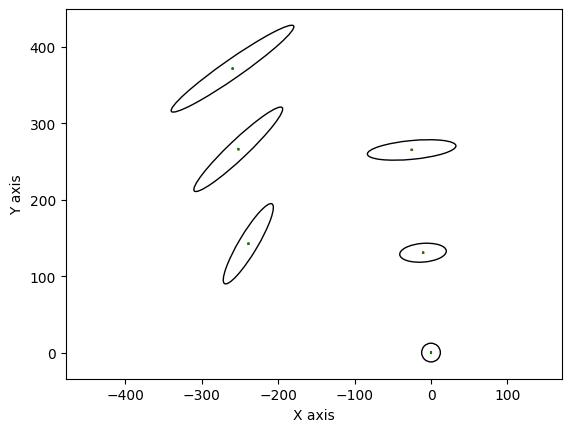

In [6]:
import gtsam.utils.plot as gtsam_plot
for i in range(0, len(images)):
    gtsam_plot.plot_pose2(0, initial_estimate.atPose2(i), 0.5,
                          marginals_before.marginalCovariance(i))
plt.axis('equal'); plt.show()

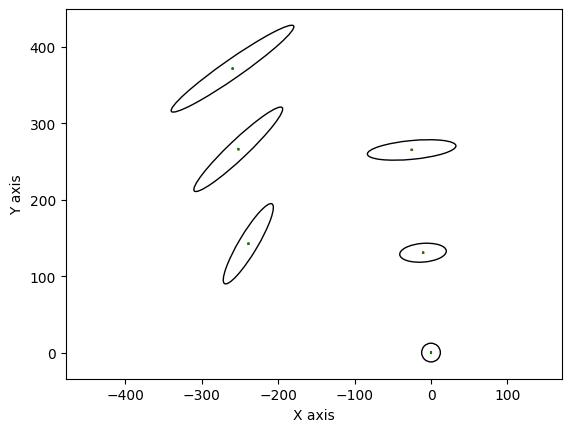

In [7]:
for i in range(0, len(images)):
    gtsam_plot.plot_pose2(0, optimized_values.atPose2(i), 0.5,
                          marginals_after.marginalCovariance(i))
plt.axis('equal'); plt.show()

In [8]:
import plotly.graph_objects as go
initial_poses = gtsam.utilities.extractPose2(initial_estimate)
fig = go.Figure()
fig.add_scatter(x=initial_poses[:,0], y=initial_poses[:,1], name="initial", marker=dict(color='orange'))
final_poses = gtsam.utilities.extractPose2(optimized_values)
fig.add_scatter(x=final_poses[:,0], y=final_poses[:,1], name="optimized", marker=dict(color='green'))
fig.update_yaxes(scaleanchor = "x",scaleratio = 1); fig.show()

In [9]:
# Plot edges and vertices of each image with its covariance
def plot_graph(values, graph, marginals):

    for vertex_index in range(values.size()): # For each vertex, plot the 2D pose with its covariance
        gtsam.utils.plot.plot_pose2(0, values.atPose2(vertex_index), 0.5, marginals.marginalCovariance(vertex_index))

    for edge_index in range(graph.size())[1:]: # For each edge, get the keys and plot the start and end pose at those keys
        key1, key2 = graph.at(edge_index).keys()

        start_pose = values.atPose2(key1)
        end_pose = values.atPose2(key2)
        plt.plot([start_pose.x(), end_pose.x()],
                 [start_pose.y(), end_pose.y()],
                 color='blue')

    plt.show()

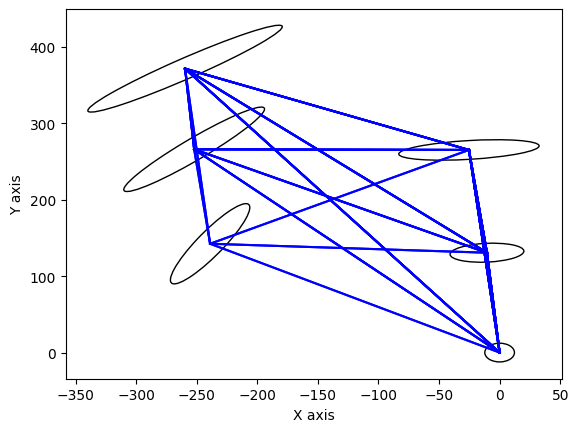

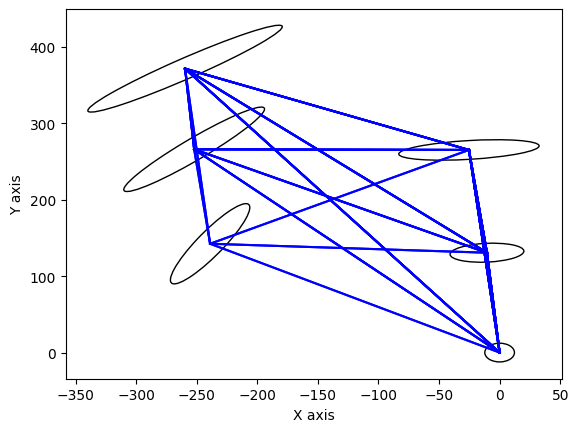

In [10]:
# marginals = gtsam.Marginals(graph, initial_estimate)
plot_graph(initial_estimate, graph, marginals_before)
plot_graph(optimized_values, graph, marginals_after)

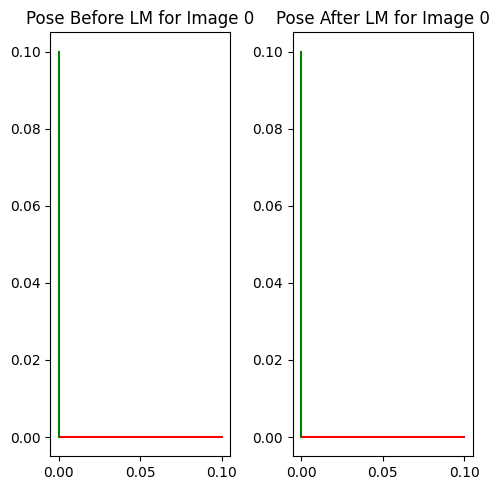

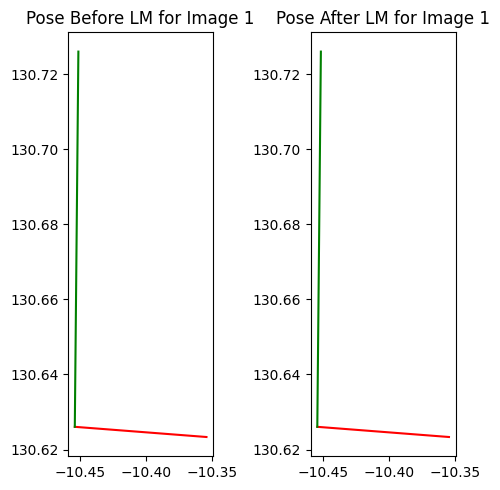

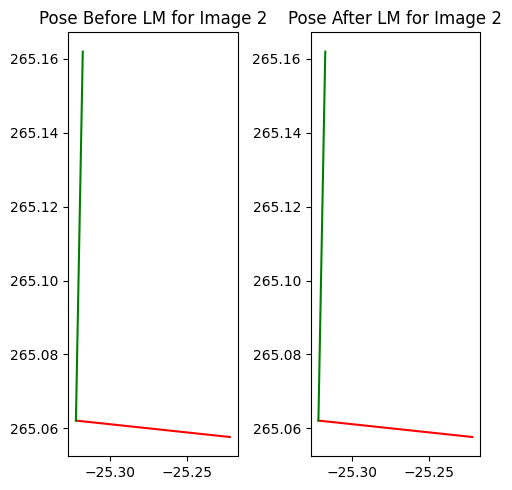

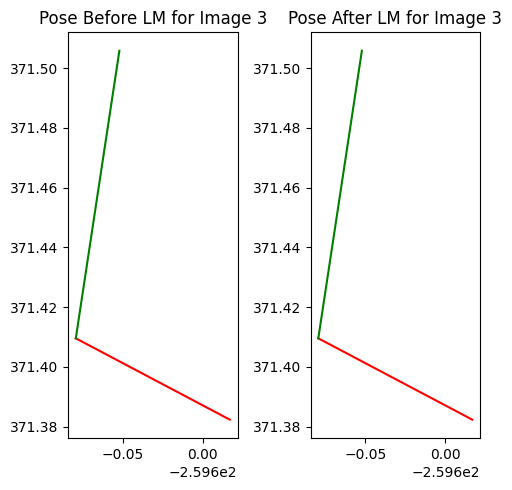

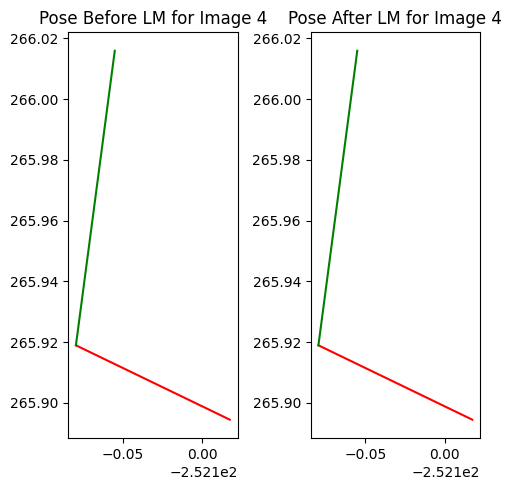

In [11]:
# Plot the poses individually before and after LM optimization
for i, pose_before in enumerate(ori_poses):
    plt.figure(figsize=(5, 5))  # Adjust the figure size as needed
    plt.subplot(121)  # Left subplot for before LM optimization
    plt.title(f'Pose Before LM for Image {i}')
    gtsam_plot.plot_pose2_on_axes(plt.gca(), pose_before, axis_length=0.1)  # Adjust axis_length as needed

    plt.subplot(122)  # Right subplot for after LM optimization
    plt.title(f'Pose After LM for Image {i}')
    gtsam_plot.plot_pose2_on_axes(plt.gca(), optimized_poses[i], axis_length=0.1)  # Adjust axis_length as needed

    plt.tight_layout()
    plt.show()